CONTENTS:
- [Exploratory Data Analysis: Gridstatus metadata](#exploratory-data-analysis:-gridstatus-metadata)
  - [Imports](#imports)
  - [Helper Functions](#helper-functions)
  - [Load Data](#load-data)
  - [Create Dataset Categories](#create-dataset-categories)
  - [Initial observation](#initial-observation)
  - [Missing Value Summary](#missing-value-summary)
      - [Exploring Gaps in Metadata Coverage](#exploring-gaps-in-metadata-coverage)
  - [Exploratory Analysis](#exploratory-analysis)
      - [Source Distribution](#source-distribution)
      - [Frequency Distribution](#frequency-distribution)
      - [Category Distribution](#category-distribution)
      - [Lookback Period](#lookback-period)
      - [Dataset Coverage Distribution](#dataset-coverage-distribution)
      - [Coverage Insights by Frequency and Snowflake Ingestion](#coverage-insights-by-frequency-and-snowflake-ingestion)
      - [Snowflake Ingestion Insights by Table Type](#snowflake-ingestion-insights-by-table-type)
      - [Analysis of Potentially Discontinued Series](#analysis-of-potentially-discontinued-series)
      - [Coverage by Source and Category](#coverage-by-source-and-category)

<a name='exploratory-data-analysis:-gridstatus-metadata'></a>
# Exploratory Data Analysis: Gridstatus metadata

This notebook analyzes the metadata of time series datasets available on GridStatus.io. The goal is to explore the variety, coverage, and quality of the available time series data.

<a name='imports'></a>
## Imports

In [ ]:
import io
import logging
import re
from typing import Dict, Optional

import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hs3 as hs3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [71]:
# Configure logger.
hdbg.init_logger(verbosity=logging.INFO)
_LOG = logging.getLogger(__name__)

# Print system signature.
_LOG.info("%s", henv.get_system_signature()[0])

# Configure the notebook style.
hprint.config_notebook()

INFO  # Git
  branch_name='TutorTask236_EDA_gridstatus_metadata'
  hash='0f06080'
  # Last commits:
    * 0f06080 Allen Mathews Styling and other nits                                            (   4 hours ago) Fri May 2 17:18:05 2025  (HEAD -> TutorTask236_EDA_gridstatus_metadata, origin/TutorTask236_EDA_gridstatus_metadata)
    * 4f3d7bc Allen Mathews Additional changes and linter checks                              (  26 hours ago) Thu May 1 19:28:29 2025           
    * 8facab4 Allen Mathews Updated bucket path                                               (    2 days ago) Thu May 1 02:52:02 2025           
# Machine info
  system=Linux
  node name=d097c9782714
  release=6.10.14-linuxkit
  version=#1 SMP Mon Feb 24 16:35:16 UTC 2025
  machine=aarch64
  processor=aarch64
  cpu count=11
  cpu freq=None
  memory=svmem(total=8217890816, available=7076188160, percent=13.9, used=972275712, free=6513041408, active=1252216832, inactive=221724672, buffers=57683968, cached=674889728, shared

<a name='helper-functions'></a>
## Helper Functions

In [72]:
def _categorize_series(name: str, category_keywords: Dict[str, str]) -> str:
    """
    Categorize a dataset based on keywords in its name.

    :param name: name of the time series
    :param category_keywords: keywords mapped to categories
    :return: category label
    """
    name = str(name).lower()
    for category, keyword in category_keywords.items():
        # Match name to category keyword pattern.
        if re.search(keyword, name):
            return category
    return "Other"


def _make_plots(
    *,
    title: Optional[str] = None,
    x_label: Optional[str] = None,
    y_label: Optional[str] = None,
    x_rotation: Optional[int] = None,
    y_rotation: Optional[int] = None,
    legend: Optional[str] = None,
    grid: bool = False,
) -> None:
    """
    Generate a plot with the given parameters.

    :param title: title of the plot
    :param x_label: x-axis label
    :param y_label: y-axis label
    :param legend: legend title
    :param x_rotation: rotation angle for x-axis labels
    :param y_rotation: rotation angle for y-axis labels
    :param grid: display grid if True
    """
    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    if x_rotation is not None:
        plt.xticks(rotation=x_rotation)
    if y_rotation is not None:
        plt.yticks(rotation=y_rotation)
    if legend is not None:
        plt.legend(title=legend)
    if grid:
        plt.grid(grid)
    plt.show()


def _display_percentage_plot(df: pd.DataFrame, column: str) -> None:
    """
    Generate bar plot with percentage distribution.

    :param df: input dataframe
    :param column: column to visualize as a percentage distribution
    """
    column_counts = df[column].value_counts()
    ax = column_counts.plot(kind="bar", figsize=(9, 5))
    for index, percentage in enumerate(column_counts / len(df) * 100):
        ax.text(
            index,
            column_counts.iloc[index],
            f"{percentage:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )


def _get_missing_count(df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize missing values per column.

    :param df: data to check for missing values
    :return: data with count and percentage of missing values
    """
    missing_count = df.isna().sum().sort_values(ascending=False)
    missing_percent = (
        (df.isna().mean() * 100).sort_values(ascending=False).round(2)
    )
    missing_columns_count = pd.DataFrame(
        {"Missing Count": missing_count, "Missing %": missing_percent}
    )
    missing_columns_df = missing_columns_count[
        missing_columns_count["Missing Count"] > 0
    ]
    return missing_columns_df

<a name='load-data'></a>
## Load Data

In [73]:
# Display structure of the data.
def _load_data(file_path: str) -> pd.DataFrame:
    """
    Load data from file path to a dataframe.

    :param file_path: path of the data to load from
    :return: dataframe of the loaded data
    """
    file = hs3.from_file(file_path, aws_profile="ck")
    df = pd.read_csv(io.StringIO(file))
    _LOG.info("shape: %s", df.shape)
    _LOG.info("columns: %s", df.columns)
    _LOG.info("df: \n %s", hpandas.df_to_str(df, log_level=logging.INFO))
    return df


file_path = "s3://causify-data-collaborators/causal_automl/metadata/gridstatus_metadata_original_v1.0.csv"
gs_meta = _load_data(file_path)

INFO  shape: (268, 19)
INFO  columns: Index(['id', 'name', 'description', 'earliest_available_time_utc', 'latest_available_time_utc', 'source', 'last_checked_time_utc', 'primary_key_columns', 'publish_time_column', 'time_index_column', 'subseries_index_column', 'all_columns', 'number_of_rows_approximate', 'table_type', 'is_in_snowflake', 'data_frequency', 'source_url', 'publication_frequency', 'is_published'], dtype='object')


,id,name,description,earliest_available_time_utc,latest_available_time_utc,source,last_checked_time_utc,primary_key_columns,publish_time_column,time_index_column,subseries_index_column,all_columns,number_of_rows_approximate,table_type,is_in_snowflake,data_frequency,source_url,publication_frequency,is_published
0,all_records,All Records,Top daily records for various metrics across all ISOs,2017-12-13T22:05:00+00:00,2025-03-26T15:30:00+00:00,gridstatus,2025-04-09T15:37:14+00:00,"['iso', 'rank', 'record_type', 'metric_name']",NaN,interval_start_utc,NaN,"[{'name': 'rank', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}, {'name': 'iso', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'date', 'type': 'DATE', 'is_numeric': False, 'is_datetime': True}, {'name': 'record_type', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_name', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_value', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}]",620,materialized_view,False,IRREGULAR,NaN,NaN,True
1,all_records_timeseries,All Records Timeseries,Timeline of new records for various metrics in all ISOs,2011-01-01T06:30:00+00:00,2025-03-25T00:40:00+00:00,gridstatus,2025-04-09T15:37:14+00:00,"['iso', 'interval_start_utc', 'record_type', 'metric_name']",NaN,interval_start_utc,NaN,"[{'name': 'iso', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'date', 'type': 'DATE', 'is_numeric': False, 'is_datetime': True}, {'name': 'record_type', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_name', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_value', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}]",2076,materialized_view,False,IRREGULAR,NaN,NaN,True
2,caiso_as_prices,CAISO AS Prices,Ancillary Services Prices as reported by CAISO.\n\n**AS Mapping**\n\nThe *_EXP show only the intertie resources.\n \n- AS_SP26_P: Resources in AS_SP26\n- AS_NP26_P: Resources in AS_NP26\n- AS_SP15_P: Resources in AS_SP15\n- AS_NP15_P: Resources in AS_NP15\n- AS_SP26_EXP_P: Resources in AS_SP26_EXP which are not in AS_SP26\n- AS_NP26_EXP_P: Resources in AS_NP26_EXP which are not in AS_NP26\n- AS_SP15_EXP_P: Resources in AS_SP15_EXP which are not in AS_SP15\n- AS_NP15_EXP_P: Resources in AS_NP15_EXP which are not in AS_NP15\n- AS_CAISO_NP26_P: Resources in AS_CAISO which are not in AS_SP26\n- AS_CAISO_SP26_P: Resources in AS_CAISO which are not in AS_NP26\n- AS_CAISO_NP15_P: Resources in AS_CAISO which are not in AS_SP15\n- AS_CAISO_SP15_P: Resources in AS_CAISO which are not in AS_NP15,2010-01-01T08:00:00+00:00,2025-04-10T06:00:00+00:00,caiso,2025-04-09T15:37:12+00:00,"['interval_start_utc', 'region', 'market']",NaN,interval_start_utc,region,"[{'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_end_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'region', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'market', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'non_spinning_reserves', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_down', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_mileage_down', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_mileage_up', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_up', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'spinning_reserves', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': Fals

INFO  df: 
 None


<a name='create-dataset-categories'></a>
## Create Dataset Categories

Categorize datasets by matching names to keyword patterns.

In [74]:
# Define categories.
category_keywords = {
    "Energy": r"\b(load|energy)\b",
    "Renewables": r"\b(renewable|solar|wind|hydro)\b",
    "Non-renewables": r"\bnatural gas\b",
    "Fuel Mix": r"\bfuel\b",
    "Prices": r"\b(price|prices|pricing|spp|lmp)\b",
    "Power": r"\b(power|electric|outages)\b",
    "Emissions": r"\b(emission|emissions)\b",
    "Weather": r"\b(weather|temperature)\b",
    "Capacity": r"\b(capacity)\b",
    "Records": r"\b(record|records|statistics)\b",
    "Time Frequency": r"\b(day|daily|hour|hourly|minute|min)\b",
}
gs_meta["category"] = gs_meta["name"].apply(
    lambda name: _categorize_series(name, category_keywords)
)
_LOG.info(
    "metadata with categories: \n %s",
    hpandas.df_to_str(gs_meta, log_level=logging.INFO),
)

,id,name,description,earliest_available_time_utc,latest_available_time_utc,source,last_checked_time_utc,primary_key_columns,publish_time_column,time_index_column,subseries_index_column,all_columns,number_of_rows_approximate,table_type,is_in_snowflake,data_frequency,source_url,publication_frequency,is_published,category
0,all_records,All Records,Top daily records for various metrics across all ISOs,2017-12-13T22:05:00+00:00,2025-03-26T15:30:00+00:00,gridstatus,2025-04-09T15:37:14+00:00,"['iso', 'rank', 'record_type', 'metric_name']",NaN,interval_start_utc,NaN,"[{'name': 'rank', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}, {'name': 'iso', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'date', 'type': 'DATE', 'is_numeric': False, 'is_datetime': True}, {'name': 'record_type', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_name', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_value', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}]",620,materialized_view,False,IRREGULAR,NaN,NaN,True,Records
1,all_records_timeseries,All Records Timeseries,Timeline of new records for various metrics in all ISOs,2011-01-01T06:30:00+00:00,2025-03-25T00:40:00+00:00,gridstatus,2025-04-09T15:37:14+00:00,"['iso', 'interval_start_utc', 'record_type', 'metric_name']",NaN,interval_start_utc,NaN,"[{'name': 'iso', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'date', 'type': 'DATE', 'is_numeric': False, 'is_datetime': True}, {'name': 'record_type', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_name', 'type': 'TEXT', 'is_numeric': False, 'is_datetime': False}, {'name': 'metric_value', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}]",2076,materialized_view,False,IRREGULAR,NaN,NaN,True,Records
2,caiso_as_prices,CAISO AS Prices,Ancillary Services Prices as reported by CAISO.\n\n**AS Mapping**\n\nThe *_EXP show only the intertie resources.\n \n- AS_SP26_P: Resources in AS_SP26\n- AS_NP26_P: Resources in AS_NP26\n- AS_SP15_P: Resources in AS_SP15\n- AS_NP15_P: Resources in AS_NP15\n- AS_SP26_EXP_P: Resources in AS_SP26_EXP which are not in AS_SP26\n- AS_NP26_EXP_P: Resources in AS_NP26_EXP which are not in AS_NP26\n- AS_SP15_EXP_P: Resources in AS_SP15_EXP which are not in AS_SP15\n- AS_NP15_EXP_P: Resources in AS_NP15_EXP which are not in AS_NP15\n- AS_CAISO_NP26_P: Resources in AS_CAISO which are not in AS_SP26\n- AS_CAISO_SP26_P: Resources in AS_CAISO which are not in AS_NP26\n- AS_CAISO_NP15_P: Resources in AS_CAISO which are not in AS_SP15\n- AS_CAISO_SP15_P: Resources in AS_CAISO which are not in AS_NP15,2010-01-01T08:00:00+00:00,2025-04-10T06:00:00+00:00,caiso,2025-04-09T15:37:12+00:00,"['interval_start_utc', 'region', 'market']",NaN,interval_start_utc,region,"[{'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_end_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'region', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'market', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'non_spinning_reserves', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_down', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_mileage_down', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_mileage_up', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'regulation_up', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'spinning_reserves', 'type': 'DOUBLE PRECISION', 'is_numeric': 

INFO  metadata with categories: 
 None


<a name='initial-observation'></a>
## Initial observation

From the 19 columns available in the GridStatus metadata, the following are most relevant for initial exploratory analysis:

- `source` : Identifies the origin of each dataset.
- `data_frequency` : Describes the granularity of data (e.g. 5 minutes, 1 hour, 1 day, etc).
- `is_in_snowflake` : Indicates whether the dataset is already ingested into the internal Snowflake warehouse.
- `table_type` : Helps categorize datasets by their structure or intended purpose (table, view, materialized view).
- `earliest_available_time_utc` : Indicates the starting point of data availability for each dataset.
- `latest_available_time_utc` : Indicates the most recent timestamp available in each dataset.


Several other metadata fields are available but were excluded from the initial analysis for the following reasons:

- Columns like `id`, `name`, and `description` are identifiers or unstructured text, making them unsuitable for analysis.
- Fields like `primary_key_columns`, `publish_time_column`, `subseries_index_column`, and `all_columns` are helpful for database structure but not very useful for analyzing overall metadata patterns.
- Fields like `last_checked_time_utc` are useful for monitoring and tracking system activity.
- `source_url` is similar to `source`, as it includes a direct link to the data source, but it contains some null values and may not always be available.
- `number_of_rows_approximate` can be leveraged in future analytical processes to perform dataset size comparisons, enabling scalability assessments and optimization strategies.
- `time_index_column` indicates the name of the column containing timestamps, making it useful for dataset structure but not for actual time-based analysis.
- `is_published` is consistently `True` for all records (unless the metadata is updated) and therefore not relevant for analysis.
- `publication_frequency` is null for all records except one, and as a result, it is excluded from the analysis.

<a name='missing-value-summary'></a>
## Missing Value Summary

The table below shows the number of missing (null) values in each metadata field, helping identify potential data quality issues.

,Missing Count,Missing %
publication_frequency,267,99.63
publish_time_column,198,73.88
subseries_index_column,161,60.07
,...,...
table_type,4,1.49
data_frequency,2,0.75
description,1,0.37


INFO  missing data: 
None


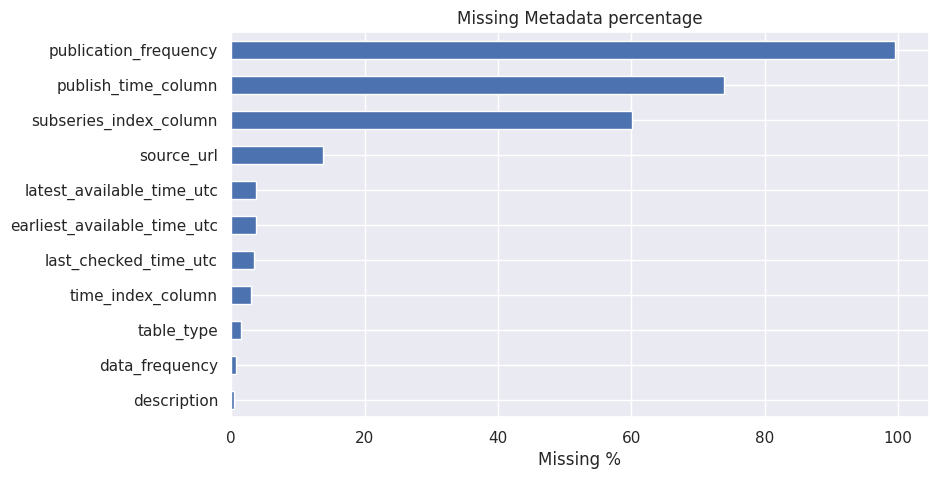

In [75]:
# Display missing metadata statistics.
missing_gs_meta = _get_missing_count(gs_meta)
_LOG.info(
    "missing data: \n%s",
    hpandas.df_to_str(missing_gs_meta, log_level=logging.INFO),
)
# Plot missing metadata statistics.
missing_gs_meta[missing_gs_meta["Missing Count"] > 0].sort_values(
    "Missing %", ascending=True
)["Missing %"].plot(
    kind="barh", figsize=(9, 5), title="Missing Metadata percentage"
)
_make_plots(x_label="Missing %", grid=True)

<a name='exploring-gaps-in-metadata-coverage'></a>
#### Exploring Gaps in Metadata Coverage

- The metadata gaps are due to data unavailability, not scraping issues. This is confirmed by cross-checking with the GridStatus website.
- Fields with the most gaps are publication_frequency (99.63%), publish_time_column (73.88%), subseries_index_column (60.07%).
- Some source URLs (13.81%) may be missing, but since the `source` field still identifies the origin of the dataset, their absence does not significantly hinder metadata interpretation.
- The remaining fields have only a small number of missing values, upto 4%.

<a name='exploratory-analysis'></a>
## Exploratory Analysis


<a name='source-distribution'></a>
#### Source Distribution

Over 50% of all datasets come from ERCOT, PJM, and CAISO, indicating better data availability, reliability, or greater importance in grid operations.

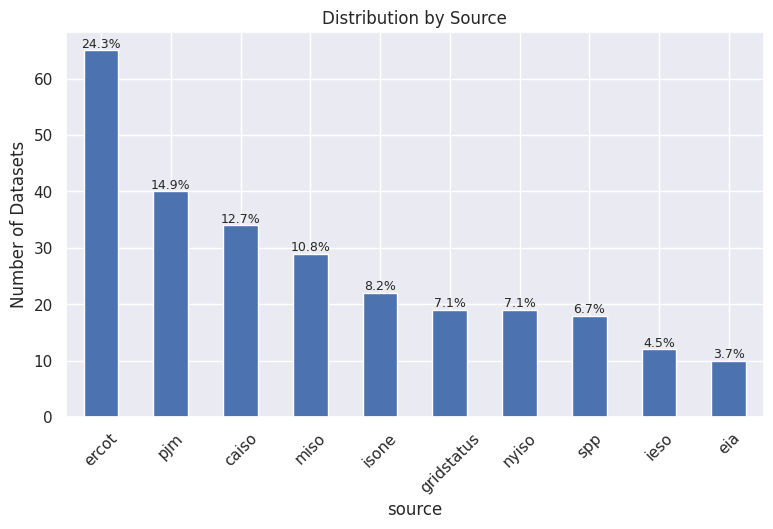

In [76]:
# Plot the distribution of entries by source.
_display_percentage_plot(gs_meta, column="source")
_make_plots(
    title="Distribution by Source", y_label="Number of Datasets", x_rotation=45
)

<a name='frequency-distribution'></a>
#### Frequency Distribution

Most of the datasets in GridStatus are updated frequently, with the majority (almost 75% of the datasets) being updated hourly or every 5 minutes. This suggests that the system is focused on providing up-to-date, real-time data, while fewer datasets cater to more specialized or less frequent data needs.

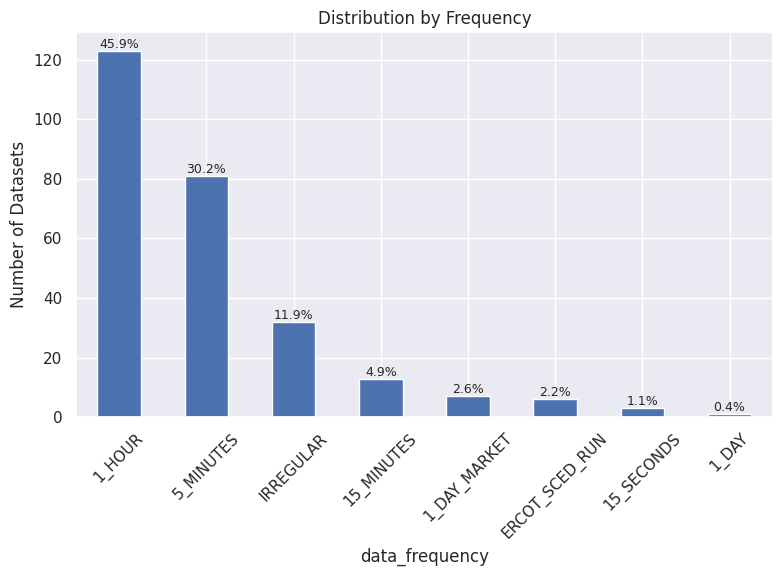

In [77]:
# Plot the distribution of entries by frequency.
_display_percentage_plot(gs_meta, column="data_frequency")
_make_plots(
    title="Distribution by Frequency", y_label="Number of Datasets", x_rotation=45
)

<a name='category-distribution'></a>
#### Category Distribution

Around 60% of the dataset fall under the category of Price, Energy and Time Frequency. Categories such as Capacity, Emissions, Non-renewables and Weather account to less than 3% of the dataset. Additionally, nearly 10% of the dataset does not fall under any defined category. This can be reduced by fine-tuning the categorization process, by using a different metadata field, such as description.

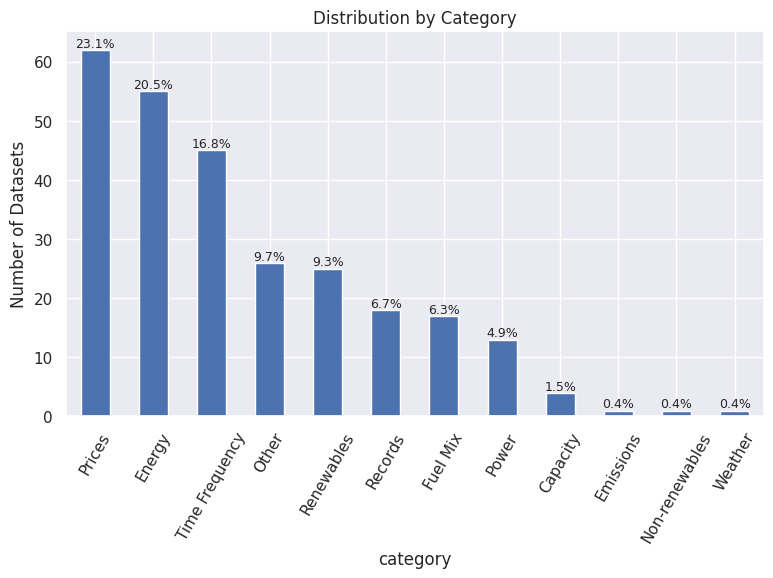

In [78]:
# Plot the distribution of entries by category.
_display_percentage_plot(gs_meta, column="category")
_make_plots(
    title="Distribution by Category", y_label="Number of Datasets", x_rotation=60
)

<a name='lookback-period'></a>
#### Lookback Period

The earliest available datasets indicate a few sources with historical data dating back to 1993 and the early 2000s, suggesting the presence of long-term historical records. However, the majority of datasets begin around 2010 or later, with a noticeable drop in availability in 2020.

In [79]:
# Convert timestamps to DateTime format.
gs_meta["earliest_available_time_utc"] = pd.to_datetime(
    gs_meta["earliest_available_time_utc"]
)
gs_meta["latest_available_time_utc"] = pd.to_datetime(
    gs_meta["latest_available_time_utc"]
)

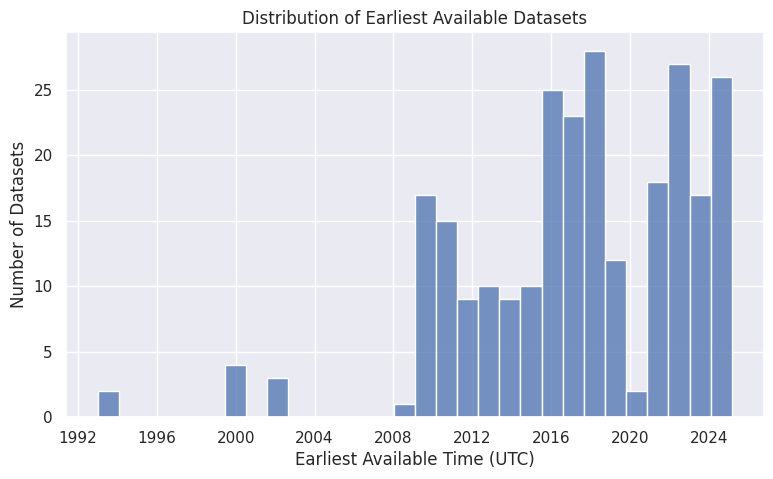

In [80]:
# Plot a histogram of the earliest available datasets.
plt.figure(figsize=(9, 5))
sns.histplot(gs_meta["earliest_available_time_utc"].dropna(), bins=30, kde=False)
_make_plots(
    title="Distribution of Earliest Available Datasets",
    x_label="Earliest Available Time (UTC)",
    y_label="Number of Datasets",
)

In [81]:
# Display the dataset(s) with the earliest available time.
earliest_rows = gs_meta[
    gs_meta["earliest_available_time_utc"]
    == gs_meta["earliest_available_time_utc"].min()
]
print("Earliest available dataset(s):")
_LOG.info(
    "earliest available dataset(s): \n%s",
    hpandas.df_to_str(earliest_rows, log_level=logging.INFO),
)

Earliest available dataset(s):


,id,name,description,earliest_available_time_utc,latest_available_time_utc,source,last_checked_time_utc,primary_key_columns,publish_time_column,time_index_column,subseries_index_column,all_columns,number_of_rows_approximate,table_type,is_in_snowflake,data_frequency,source_url,publication_frequency,is_published,category
222,pjm_load_metered_hourly,PJM Load Metered Hourly,"The MWh net energy consumption by each service territory within PJM. Data is further broken up into NERC region, zone, and load areas.",1993-01-01 05:00:00+00:00,2025-04-08 03:00:00+00:00,pjm,2025-04-09T15:38:01+00:00,"['interval_start_utc', 'mkt_region', 'zone', 'load_area']",NaN,interval_start_utc,load_area,"[{'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_end_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'nerc_region', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'mkt_region', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'zone', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'load_area', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'mw', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'is_verified', 'type': 'BOOLEAN', 'is_numeric': False, 'is_datetime': False}]",5681485,table,True,1_HOUR,https://dataminer2.pjm.com/feed/hrl_load_metered/definition,NaN,True,Energy


INFO  earliest available dataset(s): 
None


<a name='dataset-coverage-distribution'></a>
#### Dataset Coverage Distribution

The distribution of dataset coverage follows a clear multimodal pattern, with the Kernel Density Estimate (KDE) curve showing a concentration of datasets around 8-10 years, indicating that most datasets provide medium-term historical coverage. There is also a significant concentration around 3 years, reflecting a large number of more recent datasets. The curve shows a noticeable gap after 14-15 years, suggesting fewer datasets with coverage beyond this point. This pattern highlights the availability of datasets across various time spans, from recent data to long-term historical records, while pointing to a potential gap in coverage for datasets lasting beyond 15 years.

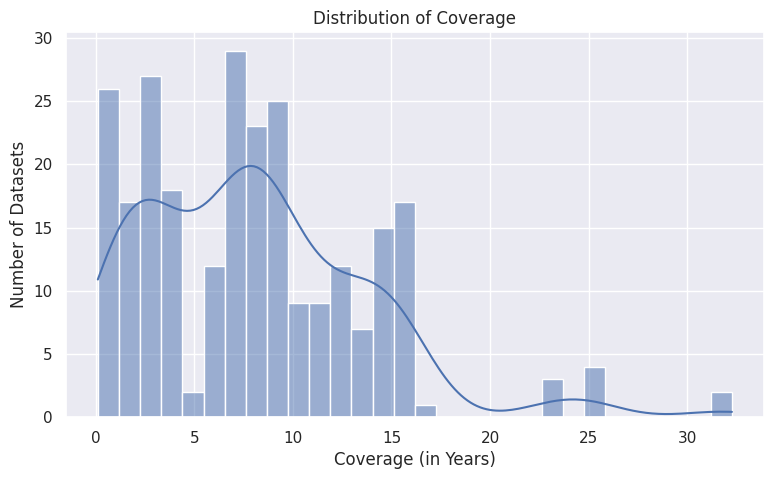

In [82]:
# Plot the distribution of dataset coverage with a Kernel Density Estimate (KDE) overlay.
gs_meta["coverage"] = (
    gs_meta["latest_available_time_utc"] - gs_meta["earliest_available_time_utc"]
).dt.days / 365.25
plt.figure(figsize=(9, 5))
sns.histplot(gs_meta["coverage"], bins=30, kde=True)
_make_plots(
    title="Distribution of Coverage",
    x_label="Coverage (in Years)",
    y_label="Number of Datasets",
    grid=True,
)

<a name='coverage-insights-by-frequency-and-snowflake-ingestion'></a>
#### Coverage Insights by Frequency and Snowflake Ingestion

The distribution of coverage durations across data frequencies reveals that the majority of datasets fall under the ‘1 hour’ and ‘5 mins’ categories (as shown in the previous graphs), reflecting a clear emphasis on high-resolution time series data. Notably, most of these high-frequency datasets are already ingested into Snowflake, suggesting that ingestion efforts are prioritized for data streams that support real-time or near-real-time analytics.

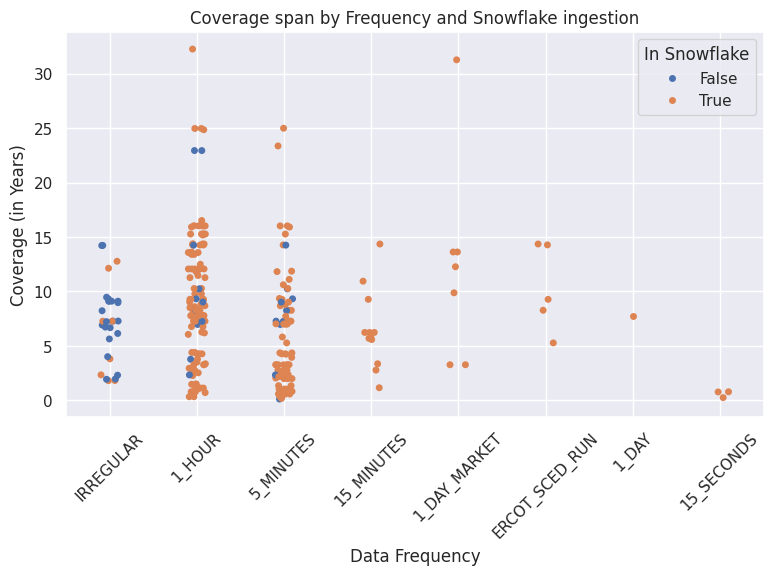

In [83]:
# Plot coverage span by data frequency, colored by Snowflake status.
plt.figure(figsize=(9, 5))
sns.stripplot(
    data=gs_meta,
    x="data_frequency",
    y="coverage",
    hue="is_in_snowflake",
    jitter=True,
)
_make_plots(
    title="Coverage span by Frequency and Snowflake ingestion",
    x_label="Data Frequency",
    y_label="Coverage (in Years)",
    legend="In Snowflake",
    x_rotation=45,
    grid=True,
)

<a name='snowflake-ingestion-insights-by-table-type'></a>
#### Snowflake Ingestion Insights by Table Type

```is_in_snowflake``` tells us what data is ready for the analytics team to use and what might still be missing from the system, while ```table_type``` distinguishes between how data is structured and consumed. Together, they highlight the current state of data integration and readiness across the warehouse. Understanding these gaps can inform ingestion priorities and surface potential blind spots in data accessibility.

The analysis of Snowflake ingestion shows some interesting patterns across different data types. All `materialized_view` entries and around 90% of `view` entries are not ingested into Snowflake. On the other hand, around 95% of `table_view` entries are successfully ingested into Snowflake, showing that most structured data is already in the system.


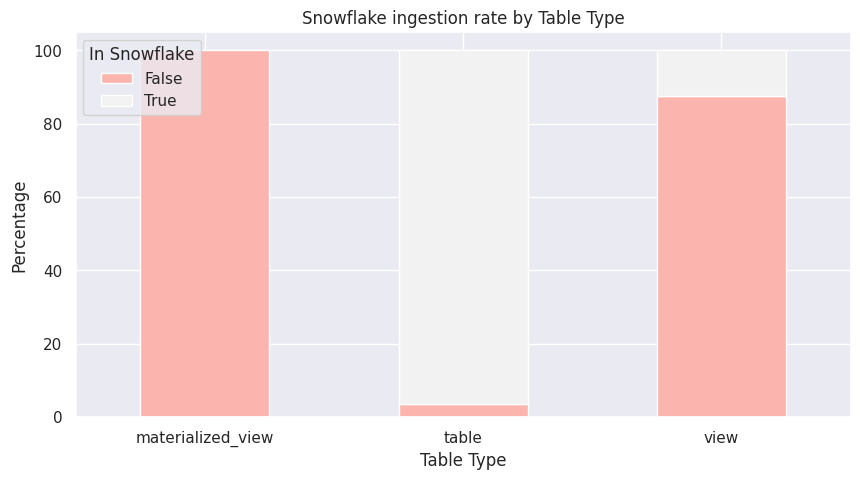

In [84]:
# Plot a normalized stacked bar chart of Snowflake ingestion by table type.
sf_by_ttype = (
    pd.crosstab(
        gs_meta["table_type"], gs_meta["is_in_snowflake"], normalize="index"
    )
    * 100
)
sf_by_ttype.plot(kind="bar", stacked=True, figsize=(10, 5), colormap="Pastel1")
_make_plots(
    title="Snowflake ingestion rate by Table Type",
    x_label="Table Type",
    y_label="Percentage",
    legend="In Snowflake",
    x_rotation=0,
    grid=True,
)

<a name='analysis-of-potentially-discontinued-series'></a>
#### Analysis of Potentially Discontinued Series

This plot visualizes the number of time series grouped by the number of days since their most recent data point ```latest_available_time_utc```. Time series with a high number of days since the last update may indicate that the datasets are potentially discontinued or inactive. A threshold of 120 days has been set to flag series that are potentially outdated, helping to identify datasets that may require further review for reactivation, archival, or removal. This approach provides a proactive way to monitor the health and relevance of time series in the data pipeline.

In [85]:
# Identify discontinued datasets.
gs_meta["days_since_latest_data"] = (
    pd.Timestamp.utcnow() - gs_meta["latest_available_time_utc"]
).dt.days
discontinued_threshold = 120
discontinued_data = gs_meta[
    gs_meta["days_since_latest_data"] > discontinued_threshold
]
_LOG.info(
    "discontinued data: \n%s",
    hpandas.df_to_str(discontinued_data, log_level=logging.INFO),
)

,id,name,description,earliest_available_time_utc,latest_available_time_utc,source,last_checked_time_utc,primary_key_columns,publish_time_column,time_index_column,subseries_index_column,all_columns,number_of_rows_approximate,table_type,is_in_snowflake,data_frequency,source_url,publication_frequency,is_published,category,coverage,days_since_latest_data
6,caiso_curtailment_aggregated_hourly,CAISO Curtailment Aggregated Hourly,"CAISO curtailment aggregated by wind and solar on an hourly basis. For more granular data, on curtailment type and reason, see the caiso_curtailment dataset.",2016-06-30 07:00:00+00:00,2023-09-29 01:00:00+00:00,caiso,NaN,['interval_start_utc'],NaN,interval_start_utc,NaN,"[{'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_end_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'wind_curtailment_mwh', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}, {'name': 'wind_curtailment_mw', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}, {'name': 'solar_curtailment_mwh', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}, {'name': 'solar_curtailment_mw', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}, {'name': 'total_curtailment_mwh', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}, {'name': 'total_curtailment_mw', 'type': 'BIGINT', 'is_numeric': True, 'is_datetime': False}]",-1,view,False,1_HOUR,https://www.caiso.com/about/our-business/managing-the-evolving-grid,NaN,True,Time Frequency,7.244353,581.0
106,ercot_spp_day_ahead_price_corrections,ERCOT SPP Day Ahead Price Corrections,ERCOT SPP Day Ahead Price Corrections,2012-03-07 22:45:00+00:00,2024-04-24 21:00:00+00:00,ercot,2025-04-09T15:01:08+00:00,"['location', 'interval_start_utc', 'price_correction_time_utc']",price_correction_time_utc,interval_start_utc,location,"[{'name': 'price_correction_time_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_end_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'location', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'location_type', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'spp_original', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'spp_corrected', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}]",1114520,table,True,IRREGULAR,https://www.ercot.com/mp/data-products/data-product-details?id=NP4-196-M,NaN,True,Prices,12.128679,373.0
108,ercot_spp_real_time_price_corrections,ERCOT SPP Real Time Price Corrections,ERCOT SPP Real Time Price Corrections,2012-02-27 20:37:06+00:00,2024-12-05 22:00:00+00:00,ercot,2025-04-09T15:01:12+00:00,"['location', 'interval_start_utc', 'price_correction_time_utc']",price_correction_time_utc,interval_start_utc,location,"[{'name': 'price_correction_time_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_start_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'interval_end_utc', 'type': 'TIMESTAMP', 'is_numeric': False, 'is_datetime': True}, {'name': 'location', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'location_type', 'type': 'VARCHAR', 'is_numeric': False, 'is_datetime': False}, {'name': 'spp_original', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}, {'name': 'spp_corrected', 'type': 'DOUBLE PRECISION', 'is_numeric': True, 'is_datetime': False}]",562918,table,True,IRREGULAR,https://www.ercot.com/mp/data-products/data-product-details?id=NP4-197-M,NaN,True,Prices,12.772074,147.0
125,ieso_records_timeseries,IESO New Records Timeline,Timeline of new records for IESO,2015-01-01 22:00:00+00:00,2024-06-19 23:25:00+00:00,gridstatus,2025-04-09T15:36:27+00:00,"['interval_

INFO  discontinued data: 
None


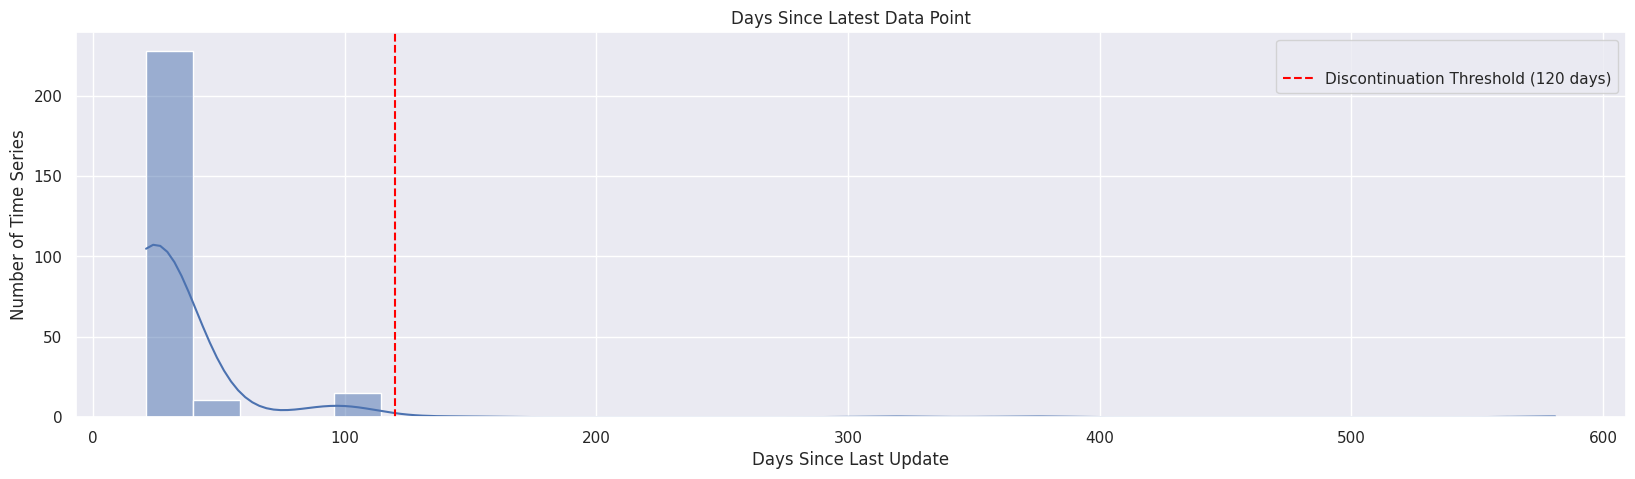

In [86]:
# Plot the distribution of days since the latest data point.
sns.histplot(gs_meta["days_since_latest_data"], bins=30, kde=True)
plt.axvline(
    discontinued_threshold,
    color="red",
    linestyle="--",
    label="Discontinuation Threshold (120 days)",
)
_make_plots(
    title="Days Since Latest Data Point",
    x_label="Days Since Last Update",
    y_label="Number of Time Series",
    legend=" ",
)

<a name='coverage-by-source-and-category'></a>
#### Coverage by Source and Category

The following heatmap shows the most popular categories across different data sources.
- ERCOT stands out for its wide range of categories, with Energy being the most popular
- GridStatus is strongly associated with the Records category
- Across all sources, Prices category is the most frequent

Categorization can be further fine-tuned using a larger number of records and more detailed metadata fields, such as descriptions, to have a better understanding of this coverage.

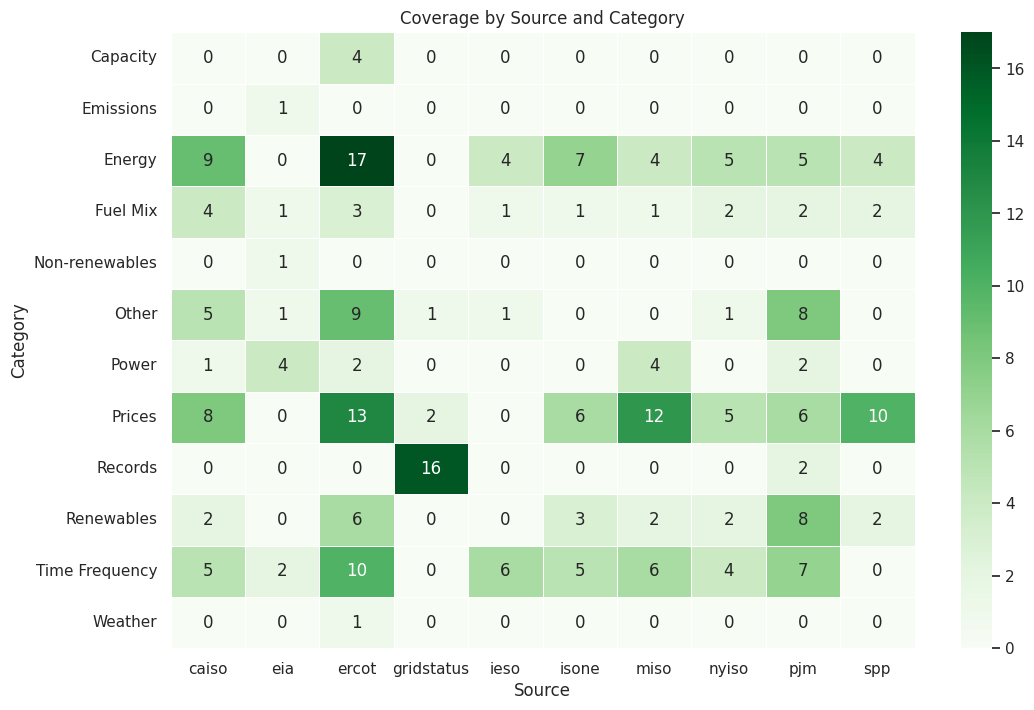

In [87]:
# Plot a heatmap to visualize the count of datasets across each source-category pair.
pivot_table = pd.pivot_table(
    gs_meta,
    values="id",
    index="category",
    columns="source",
    aggfunc="count",
    fill_value=0,
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="Greens", linewidths=0.5)
_make_plots(
    title="Coverage by Source and Category",
    x_label="Source",
    y_label="Category",
    y_rotation=0,
)